Capstone Project: Build a live camera app
=============


1. Data load and exploration
------------

- 1.1 Import modules
- 1.2 Import and extract images
- 1.3 Import and extract metadata
- 1.4 Explore digit distributions
- 1.5 Explore bounding box distributions

**1.1 Import modules**

In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd

import os
import sys
import tarfile

from IPython.display import display, Image
from scipy import ndimage
from scipy.misc import imresize

from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

**1.2 Import and extract images**

First we download the SVHN dataset from the Stanford website to the local machine.

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'

def maybe_download(folder):
  # If the files and folders are not present, download the data  
  filename = folder + '.tar.gz'
  if not os.path.exists(filename) and not os.path.isdir(folder):
    filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    print('Found: ', filename, ' File size: ', statinfo.st_size)
  else: 
    print('%s data already there' %folder)
  return filename

test_filename = maybe_download('test')
train_filename = maybe_download('train')
extra_filename = maybe_download('extra')

test data already there
train data already there
extra data already there


Extract the dataset from the compressed .tar.gz files, counting the number of images in each.

In [3]:
np.random.seed(77)

def maybe_extract(filename, force=False):
  folder = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(folder) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (folder, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % folder)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  num_files = len([name for name in os.listdir(folder) if name.endswith('png')])
  print("{} PNG files in {} folder".format(num_files, folder))
  return folder
  
train_folder = maybe_extract(train_filename)
test_folder  = maybe_extract(test_filename)
extra_folder  = maybe_extract(extra_filename)

train already present - Skipping extraction of train.tar.gz.
33402 PNG files in train folder
test already present - Skipping extraction of test.tar.gz.
13068 PNG files in test folder
extra already present - Skipping extraction of extra.tar.gz.
202353 PNG files in extra folder


Let's take a peek at some of the data to make sure it looks sensible.

train

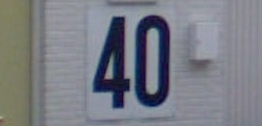

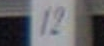

test

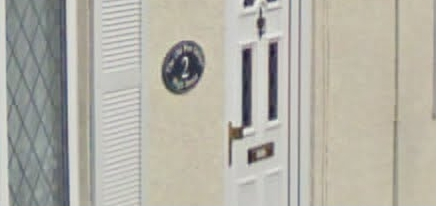

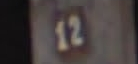

extra

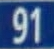

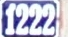

In [4]:
import random

def show_examples(folder, n_to_show = 1):
  file_list = os.listdir(folder)
  print(folder,end="")
  for _ in range(n_to_show):
    display(Image(filename=os.path.join(folder,random.choice(file_list))))
  return

show_examples(train_folder, 2)
show_examples(test_folder, 2)
show_examples(extra_folder, 2)

**1.3 Import and extract metadata**

Next we import and save the matlab metadata. Thanks to Udacity student Hang_Yao for providing the code for the DigitStructFile class.

In [38]:
import h5py

# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data

class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    # getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

    # bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    # getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
      s = self.getBbox(n)
      s['name']=self.getName(n)
      return s
  
    # getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

    # Return a restructured version of the dataset (one structure by boxed digit).
    #
    #   Return a list of such dicts :
    #      'filename' : filename of the samples
    #      'boxes' : list of such dicts (one by digit) :
    #          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
    #          'left', 'top' : position of bounding box
    #          'width', 'height' : dimension of bounding box
    #
    # Note: We may turn this to a generator, if memory issues arise.
    
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result
      
def get_digit_data(folder_name):
  # If the data has been saved as a pickle file, take it from there, otherwise calculate it
  pickle_file = folder_name + '_digit_data.pickle'
  if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as f:
      digit_data = pickle.load(f)
    print('Digit data loaded from %s.' % pickle_file)
  else:
    fin = os.path.join(folder_name, 'digitStruct.mat')
    dsf = DigitStructFile(fin)
    digit_data = dsf.getAllDigitStructure_ByDigit()
    print('%s digit data calculated.' % folder_name )
  return digit_data

def maybe_pickle(data, pickle_file, force=False):
  if os.path.exists(pickle_file) and not force:
    print('%s already present - Skipping pickling.' % pickle_file)
  else:
    print('Pickling %s.' % pickle_file)
    try:
      with open(pickle_file, 'wb') as f:  # wb means write and binary mode. returns an object of type file. 
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
      print('Unable to save data to', set_filename, ':', e)

train_digit_data = get_digit_data('train')
test_digit_data = get_digit_data('test')
extra_digit_data = get_digit_data('extra')

maybe_pickle(train_digit_data,'train_digit_data.pickle')
maybe_pickle(test_digit_data,'test_digit_data.pickle')
maybe_pickle(extra_digit_data,'extra_digit_data.pickle')


Digit data loaded from train_digit_data.pickle.
Digit data loaded from test_digit_data.pickle.
Digit data loaded from extra_digit_data.pickle.
train_digit_data.pickle already present - Skipping pickling.
test_digit_data.pickle already present - Skipping pickling.
extra_digit_data.pickle already present - Skipping pickling.


Finally, we turn the digit data into three tables: 

1. a list of image filenames
1. an array of image labels
1. and a dataframe of image bounding boxes. 

There are no zero values in the input digit data: the value of 10 is used to represent digits that are zero. So we will use zero to signify that there is no digit present.  

We then save these three tables as pickled metadata.

In [40]:
MAX_DIGITS = 6

def get_corners(box): 
  top, left, height, width = box['top'], box['left'], box['height'], box['width']
  bottom, right = top + height, left + width
  return [top, bottom, left, right]

def get_bounding_box(boxes):
  corners = np.array([get_corners(boxes[j]) for j in range(len(boxes))])
  top, bottom = np.min(corners[:,0]), np.max(corners[:,1])
  left, right = np.min(corners[:,2]), np.max(corners[:,3])
  height, width = bottom - top, right - left
  return [top, left, height, width]

def get_metadata(digit_dataset):
  
  # prepare to iterate through the dataset
  num_samples = len(digit_dataset)
  filenames   = []
  boxes_out   = np.empty([num_samples, 4])
  labels      = np.zeros([num_samples, MAX_DIGITS+1])

  # for each sample, extract the filename, bounding box and label  
  for i in range(num_samples):
    filenames.append(digit_dataset[i]['filename'])
    boxes_in       = digit_dataset[i]['boxes']
    boxes_out[i,:] = get_bounding_box(boxes_in)
    num_digits     = len(boxes_in)
    labels[i,0]    = num_digits
    for j in range(num_digits):
      labels[i,j+1] = boxes_in[j]['label']  
  boxes_out = pd.DataFrame(boxes_out, columns=['top','left','height','width']).astype('int')
  return filenames, labels, boxes_out

train_metadata = get_metadata(train_digit_data)
test_metadata  = get_metadata(test_digit_data)
extra_metadata  = get_metadata(extra_digit_data)

maybe_pickle(train_metadata,'train_metadata.pickle')
maybe_pickle(test_metadata,'test_metadata.pickle')
maybe_pickle(extra_metadata,'extra_metadata.pickle')

train_filenames, train_labels, train_boxes = train_metadata
test_filenames,  test_labels,  test_boxes  = test_metadata
extra_filenames, extra_labels, extra_boxes = extra_metadata

train_sample_count = len(train_filenames)
test_sample_count  = len(test_filenames)
extra_sample_count = len(extra_filenames)

train_metadata.pickle already present - Skipping pickling.
test_metadata.pickle already present - Skipping pickling.
Pickling extra_metadata.pickle.


**1.4 Explore digit distributions**

To further sense check the data, explore the distribution of digits and numbers of digits.

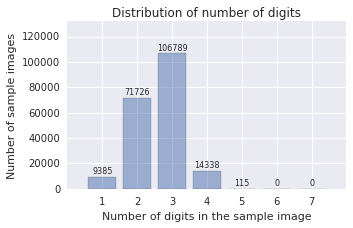

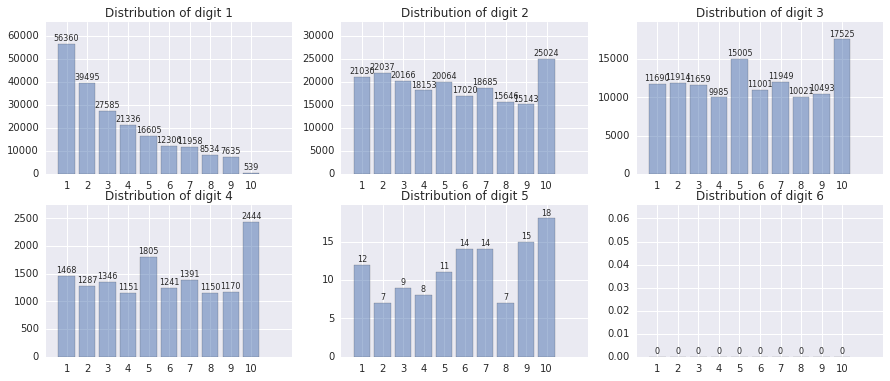

In [41]:
def make_histogram(data, max_bin, title, ax):
  hist_y, bins = np.histogram(data, bins=range(1,max_bin+2))
  hist_x = bins[:-1]
  ax.bar(hist_x,hist_y, align='center', alpha=0.5)
  ax.set_xticks(hist_x)
  ax.set_title(title)
  _, y_top = ax.get_ylim()
  ax.set_ylim(0,y_top*1.1)
  for a,b in zip(hist_x, hist_y):
    ax.text(a, b+y_top*1.1*0.02, str(b), ha='center', fontsize=8)

def show_digit_charts(labels):
  # Show distribution of number of digits
  fig, ax = plt.subplots(1, figsize=(5,3))
  make_histogram(labels[:,0],7,'Distribution of number of digits',ax)
  ax.set_xlabel('Number of digits in the sample image')
  ax.set_ylabel('Number of sample images')
  plt.show()

  # Show distribution of digits in each position
  rows, cols = 2,3
  fig, ax_list = plt.subplots(nrows=rows, ncols=cols,figsize=(5*cols,3*rows))
  for i, ax in enumerate(ax_list.flat,start=1):
    make_histogram(labels[:,i],10,'Distribution of digit '+str(i), ax)
  plt.show()

# show_digit_charts(train_labels)
# show_digit_charts(test_labels)
show_digit_charts(extra_labels)

**1.5 Explore bounding box distributions**

To understand how best to pre-process the data, explore the size and shape of bounding boxes. Start by plotting them to check the logic is right.

Label: 604


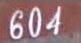

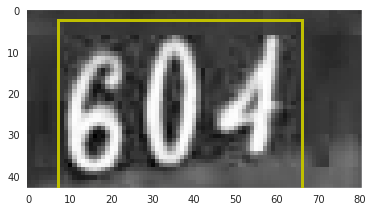

Label: 62


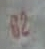

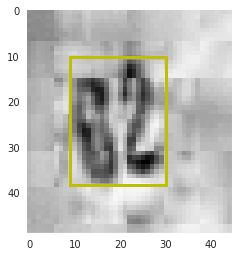

Label: 315


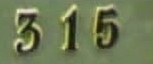

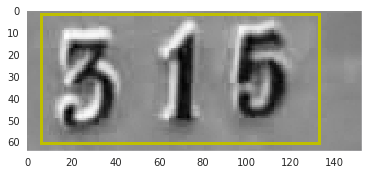

Label: 429


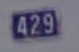

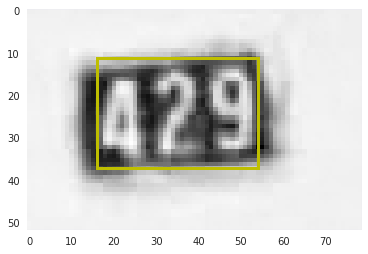

In [42]:
def label_to_text(label):
  num_digits = int(label[0])
  digits     = label[1:num_digits+1]
  digit_str  = ['0' if a==10 else str(int(a)) for a in digits]
  return ''.join(digit_str)

def show_example(folder, filenames, labels, boxes, sample):
  # get the image
  image_file = filename=os.path.join(folder,filenames[sample])
  image_data = 255 - ndimage.imread(image_file, mode='F').astype(float)
  rows, cols = image_data.shape
  
  # prepare the plot with bounding box
  fig,ax = plt.subplots(1)
  ax.imshow(image_data, interpolation='none')
  box = patches.Rectangle((boxes['left'][sample], boxes['top'][sample]),
                          boxes['width'][sample], boxes['height'][sample],
                          linewidth=3,edgecolor='y',facecolor='none')
  ax.add_patch(box)
  ax.grid(False)

  # show the image with data
  print('Label: '+label_to_text(labels[sample]))
  display(Image(image_file))
#   print ('Image size: {:>3d} x {:>3d}. Number size: {:>3d} x {:>3d}'.format(rows,cols,int(width),int(height)))
  plt.show()

for _ in range(4):
#   show_example(train_folder, train_filenames, train_labels, train_boxes, random.randrange(train_sample_count))
#   show_example(test_folder,  test_filenames,  test_labels,  test_boxes,  random.randrange(test_sample_count))
  show_example(extra_folder, extra_filenames, extra_labels, extra_boxes, random.randrange(extra_sample_count))

# let's find the big numbers
# for sample in [i for i in range(train_sample_count) if train_labels[i,0]>=5]:
#   show_example(train_filenames, train_labels, train_folder, sample)


Now show some basic statistics including the distributions of heights and widths

85% of training samples have one bounding box dimension smaller than 64 pixels after expanding by 30%

Bounding box ratios (smallest to biggest dimension):
Mean:            1:1.40 
25th percentile: 1:1.11 
50th percentile: 1:1.26 
75th percentile: 1:1.54


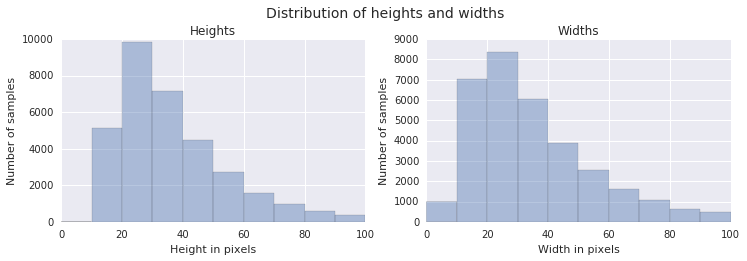

In [22]:
def print_box_stats(boxes):
  cols   = ['height','width']
  print('{:.0f}% of training samples have one bounding box dimension smaller than 64 pixels after expanding by 30%'.format(
        100*np.mean([1 if height*1.3<64 or width*1.3<64 else 0 for height, width in boxes[cols].values])))
  ratios = [width/height if width>height else height/width for height, width in boxes[cols].values]
  print('\nBounding box ratios (smallest to biggest dimension):')
  print(('Mean:            1:{:.2f} \n25th percentile: 1:{:.2f} '+
       '\n50th percentile: 1:{:.2f} \n75th percentile: 1:{:.2f}').format(
        np.mean(ratios), *np.percentile(ratios,[25,50,75])))

def show_height_width_distributions(boxes):
  cols   = ['height','width']
  titles = [a.capitalize() for a in cols]
  nrows, ncols = 1,2
  fig, ax_list = plt.subplots(nrows=nrows, ncols=ncols,figsize=(6*ncols,3.5*nrows))
  for i, ax in enumerate(ax_list.flat):
    sns.distplot(boxes[cols[i]],kde=False, bins=range(0,101,10), ax=ax)
    ax.set_title(titles[i]+'s')
    ax.set_xlabel(titles[i]+' in pixels')
    ax.set_ylabel('Number of samples')
    ax.set_xlim(0,100)
  fig.suptitle("Distribution of heights and widths", fontsize=14)
  fig.subplots_adjust(top=0.85)
  plt.show()

print_box_stats(train_boxes)
# print_box_stats(test_boxes)
show_height_width_distributions(train_boxes)
# show_height_width_distributions(test_boxes)
# show_height_width_distributions(extra_boxes)

Finally, let's explore the shapes, i.e. the aspect ratios, to see how well this will convert to a square image of fixed size as input to the model.

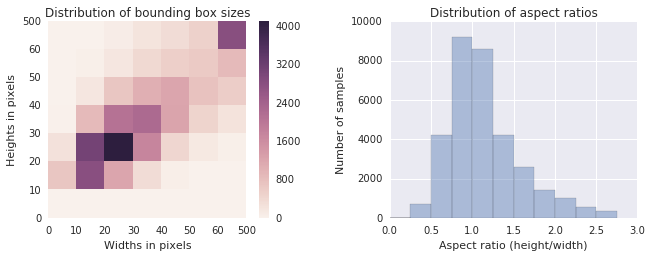

In [23]:
def plot_box_size_heatmap(boxes, ax):
  # define the edges that represent the bins to plot, and the 2d histogram data
  edges = range(0,61,10)+[500]
  hist_2d,_,_ = np.histogram2d(boxes['height'],boxes['width'], bins=edges)
  # plot it
  plt.sca(ax)
  sns.heatmap(hist_2d)
  plt.xticks(range(len(edges)), edges, rotation='horizontal')
  plt.xlabel('Widths in pixels')
  edges.reverse()
  plt.yticks(range(len(edges)), edges, rotation='horizontal')
  plt.ylabel('Heights in pixels')
  plt.gca().invert_yaxis()
  plt.title('Distribution of bounding box sizes')

def plot_aspect_ratio_distribution(boxes, ax):
  plt.sca(ax)
  ratios = boxes['height'] / boxes['width']
  sns.distplot(ratios, kde=False, bins = np.arange(0,3,0.25))
  plt.xlim(0,3)
  plt.xlabel('Aspect ratio (height/width)')
  plt.ylabel('Number of samples')
  plt.title('Distribution of aspect ratios')

fig, [ax1, ax2]= plt.subplots(nrows=1, ncols=2,figsize=(9,3.5))
plot_box_size_heatmap(train_boxes, ax1)
plot_aspect_ratio_distribution(train_boxes, ax2)
plt.tight_layout(pad=0.4, w_pad=3, h_pad=1.0)
plt.show()